# How frequently are packages updated?
In this notebook, we are going to investigate the package update frequency and extract package update behaviors.

## Import libraries and load data

In [86]:
%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

# usual imports for visualization, etc.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import datetime

# make it reproducible
np.random.seed(0)

# show plots inline
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
# data_folder = '../data/'
data_folder = 'https://zenodo.org/record/2620607/files/'

versions = pd.read_csv(data_folder + 'pypi_versions.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)

for df in [versions]:
    time_fields = []
    for col in df.columns:
        if 'timestamp' in col:
            time_fields.append(col)
    for time_field in time_fields:
        try:
            df[time_field] = df[time_field].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
        except:
            pass
        
del df

## Define helper functions and defaults

In [4]:
# Helper Functions
def add_three_months(t):
    for i in range(3):
        t = add_a_month(t)
    return t
def add_a_month(t):
    return (t.replace(day=1) + datetime.timedelta(days=31)).replace(day=1)
def print_time(t):
    return t.strftime("%Y-%m-%dT%H:%M:%S")

!mkdir figs
figs_dir = 'figs/'

mkdir: cannot create directory ‘figs’: File exists


In [6]:
from cycler import cycler
def set_plt_rc():
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    
    font = {'family': 'serif','size': BIGGER_SIZE}
    plt.rc('font', **font)

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
    plt.rcParams['font.family'] = 'serif'   
    plt.rc('axes', labelsize=8)
    plt.rc('xtick', labelsize=8)
    plt.rc('ytick', labelsize=8)
    plt.figure(figsize=(4,2.8)) 
    
set_plt_rc()

<Figure size 288x201.6 with 0 Axes>

## Number of Updates per Month over Time

In [7]:
year=pd.DatetimeIndex(versions['published_timestamp']).year
print('Range of year: ',[year.min(),year.max()])

Range of year:  [2005, 2018]


In [8]:
Year=pd.Series()
Month=pd.Series()
for i in range(2005,2019):
    Year=Year.append(pd.Series([i]*12))
    Month=Month.append(pd.Series(range(1,13)))
Year.index=range(0,168)
Month.index=range(0,168)
Number_of_Updates=pd.Series([0]*14*12)
packageUpdates=pd.concat([Year,Month,Number_of_Updates],axis=1,keys=['Year','Month','Number_of_Updates'])
for index, row in versions.iterrows():
    date=pd.Timestamp(row['published_timestamp'])
    packageUpdates.at[(date.year-2005)*12+(date.month-1),'Number_of_Updates']=packageUpdates['Number_of_Updates'][(date.year-2005)*12+(date.month-1)]+1

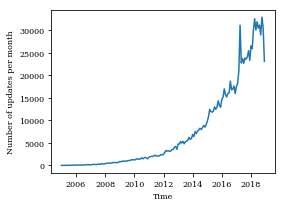

<Figure size 288x201.6 with 0 Axes>

In [71]:
plt.rc('font', size=8)
plt.rc('axes', titlesize=6)
plt.rc('axes', labelsize=8)
packageUpdates['Time']=packageUpdates['Year'].astype(str) + '-' + packageUpdates['Month'].astype(str)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
plt.plot(packageUpdates['Time'],packageUpdates['Number_of_Updates'])
ax.set_ylabel("Number of updates per month")
ax.set_xlabel('Time')
xticks=list(range(12,len(UpdateFreq_with_ChangeabilityIndex['Time']),24))
xlabels=[UpdateFreq_with_ChangeabilityIndex['Time'][x][0:4] for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=0)
fig=ax.get_figure()
fig.savefig(figs_dir + 'number-of-updates-per-month' + '.pdf',bbox_inches='tight')
fig.savefig(figs_dir + 'number-of-updates-per-month' + '.png', dpi=300,bbox_inches='tight')
set_plt_rc()

## Update Interval

In [ ]:
packageName=versions['project_name']
packageName=packageName.drop_duplicates().dropna()
packageName.index=range(0,packageName.size)
updateInterval_avg=pd.Series([0]*packageName.size)
updateInterval_min=pd.Series([0]*packageName.size)
updateInterval_max=pd.Series([0]*packageName.size)
updateInterval_median=pd.Series([0]*packageName.size)
numberOfUpdates=pd.Series([0]*packageName.size)
packageCreatedDate=pd.Series([None]*packageName.size)
packageAgeInDays=pd.Series([None]*packageName.size)
today=max(versions['published_timestamp'])
for i in range(0,packageName.size):
    packageMetadata=versions[versions['project_name']==packageName[i]]
    numberOfUpdates[i]=packageMetadata.shape[0]
    packageCreatedDate[i]=min(packageMetadata['published_timestamp'])
    packageAgeInDays[i]=(pd.Timestamp(today)-pd.Timestamp(min(packageMetadata['published_timestamp'])))/np.timedelta64(1,'D')
    published_timestamp=packageMetadata['published_timestamp']
    published_timestamp=published_timestamp.apply(lambda x: pd.Timestamp(x))
    updateInterval=published_timestamp.sort_values(ascending=True).diff().apply(lambda x: x/np.timedelta64(1,'D')).dropna()
    updateInterval_avg[i]=updateInterval.mean()
    updateInterval_min[i]=updateInterval.min()
    updateInterval_max[i]=updateInterval.max()
    updateInterval_median[i]=updateInterval.median()
UpdateFreq=pd.concat([packageName,numberOfUpdates,packageCreatedDate,packageAgeInDays,updateInterval_avg,updateInterval_min,updateInterval_max,updateInterval_median],axis=1,keys=['name','number_of_updates','created_date','age','update_interval_avg','update_interval_min','update_interval_max','update_interval_median'])
UpdateFreq.to_csv(data_folder+'UpdateFreq.csv',index=False)

In [11]:
UpdateFreq=pd.read_csv(data_folder+'UpdateFreq.csv')
print('Number of packages that never update: ', UpdateFreq['update_interval_avg'].size-UpdateFreq['update_interval_avg'].dropna().size)
print('Proporation of packages that never update: ',(UpdateFreq['update_interval_avg'].size-UpdateFreq['update_interval_avg'].dropna().size)/UpdateFreq['update_interval_avg'].size)
print('Average update interval in days: ', UpdateFreq['update_interval_avg'].dropna().mean())
print('Median of update interval in days: ', UpdateFreq['update_interval_avg'].dropna().median())
print('58% quantile of update interval in days: ', UpdateFreq['update_interval_avg'].dropna().quantile(.58))
print('25% quantile of update interval in days: ', UpdateFreq['update_interval_avg'].dropna().quantile(.25))
print('75% quantile of update interval in days: ', UpdateFreq['update_interval_avg'].dropna().quantile(.75))

Number of packages that never update:  43581
Proporation of packages that never update:  0.26757657807003005
Average update interval in days:  70.17834947123544
Median of update interval in days:  18.68533036747685
58% quantile of update interval in days:  30.250269034090906
25% quantile of update interval in days:  1.586612755847953
75% quantile of update interval in days:  73.07755883487651


## Distribution of number of package updates

In [12]:
number_of_updates=UpdateFreq['number_of_updates'].sort_values(ascending=False)
number_of_updates.index=range(0,number_of_updates.size)

In [13]:
accumulated_number_of_updates=pd.Series()
for i in range(len(number_of_updates)):
    if(i!=0):
        accumulated_number_of_updates=accumulated_number_of_updates.append(pd.Series(accumulated_number_of_updates[i-1]+number_of_updates[i],index=[i]))
    else:
        accumulated_number_of_updates=accumulated_number_of_updates.append(pd.Series(number_of_updates[i],index=[i]))
cummulative_proportion_of_updates=accumulated_number_of_updates
cummulative_proportion_of_updates=cummulative_proportion_of_updates.apply(lambda x: x*1.0/accumulated_number_of_updates[len(accumulated_number_of_updates)-1])
cummulative_proportion_of_packages=pd.Series(UpdateFreq.index+1)
num_of_packages=cummulative_proportion_of_packages.size
cummulative_proportion_of_packages=cummulative_proportion_of_packages.apply(lambda x:x*1.0/num_of_packages)

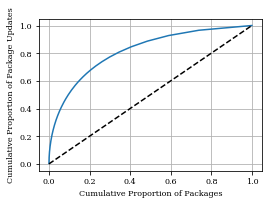

In [42]:
plt.figure(figsize=(4,2.8))
plt.plot(cummulative_proportion_of_packages,cummulative_proportion_of_updates)
plt.plot([0,1], [0,1], color='k')
plt.grid()
ax = plt.gca()
plt.xlabel('Cumulative Proportion of Packages')
plt.ylabel('Cumulative Proportion of Package Updates')
plt.savefig(figs_dir+'package-updates-distribution.pdf')
plt.savefig(figs_dir+'package-updates-distribution', dpi=300,bbox_inches='tight')

## Distribution of the number of package updates regarding package age

In [ ]:
update_age=pd.DataFrame(columns=['project_name','number','published_timestamp','update_age'])
for i in range(0,packageName.size):
    packageMetadata=versions[versions['project_name']==packageName[i]]
    numberOfUpdates=packageMetadata.shape[0]
    packageCreatedDate=min(packageMetadata['published_timestamp'])
    packageAgeInDays[i]=(pd.Timestamp(today)-pd.Timestamp(min(packageMetadata['published_timestamp'])))/np.timedelta64(1,'D')
    published_timestamp=packageMetadata['published_timestamp']
    published_timestamp=published_timestamp.apply(lambda x: pd.Timestamp(x)).sort_values(ascending=True) # Convert String to timestamp
    updateAgeInDays=published_timestamp.apply(lambda x: (x-pd.Timestamp(packageCreatedDate))/np.timedelta64(1,'D')) # Calculate update interval in days
    update=pd.concat([packageMetadata['project_name'],packageMetadata['number'],published_timestamp,updateAgeInDays],axis=1,keys=['project_name','number','published_timestamp','update_age'])
    update_age=update_age.append(update)
update_age.to_csv(data_folder+'update_age.csv',index=False)

In [15]:
update_age=pd.read_csv(data_folder+'update_age.csv')
month=pd.Series()
numberOfUpdates=pd.Series()
accumulatedNumber=pd.Series()
for i in range(120):
    month=month.append(pd.Series(i+1,index=[i]))
    numberOfUpdatesAgedInCurrentMonths=update_age[(update_age['update_age']>i*30) & (update_age['update_age']<=(i+1)*30)].shape[0]
    numberOfUpdates=numberOfUpdates.append(pd.Series(numberOfUpdatesAgedInCurrentMonths,index=[i]))
    if(i!=0):
        accumulatedNumber=accumulatedNumber.append(pd.Series(accumulatedNumber[i-1]+numberOfUpdatesAgedInCurrentMonths,index=[i]))
    else:
        accumulatedNumber=accumulatedNumber.append(pd.Series(numberOfUpdatesAgedInCurrentMonths,index=[0]))
updates_versus_age=pd.concat([month,numberOfUpdates,accumulatedNumber],axis=1,keys=['package_age_in_month','number_of_updates_happened_at_this_age','accumulated_number_of_updates'])

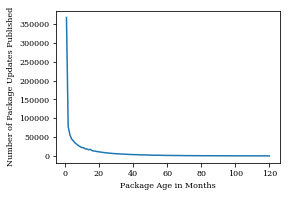

In [43]:
plt.figure(figsize=(4,2.8))
plt.plot(updates_versus_age['package_age_in_month'],updates_versus_age['number_of_updates_happened_at_this_age'])
plt.xlabel('Package Age in Months')
plt.ylabel('Number of Package Updates Published')
plt.savefig(figs_dir+'package-updates-versus-age.pdf',bbox_inches='tight')
plt.savefig(figs_dir+'package-updates-versus-age', dpi=300,bbox_inches='tight')

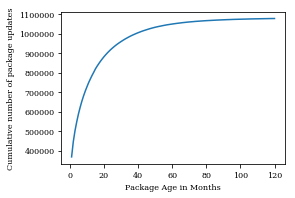

In [44]:
plt.figure(figsize=(4,2.8))
plt.plot(updates_versus_age['package_age_in_month'],updates_versus_age['accumulated_number_of_updates'],)
plt.xlabel('Package Age in Months')
plt.ylabel('Cumulative number of package updates')
plt.savefig(figs_dir+'cumulative-package-updates-versus-age.pdf',bbox_inches='tight')
plt.savefig(figs_dir+'cumulative-package-updates-versus-age', dpi=300,bbox_inches='tight')

## Changeability Index

In [ ]:
changeabilityIndex=pd.Series()
published_timestamp=versions['published_timestamp'].apply(lambda x:pd.Timestamp(x))
for i in range(packageUpdates.shape[0]):
    begin_date=pd.Timestamp(packageUpdates['Time'][i])
    end_date=pd.Timestamp(packageUpdates['Time'][i+1]) if i<packageUpdates.shape[0]-1 else pd.Timestamp('2019-01')
    versionsMetadata=versions[(published_timestamp>=begin_date) & (published_timestamp<end_date)]
    ## Calculate changeability index
    package_name=versionsMetadata['project_name'].drop_duplicates().dropna()
    package_name.index=range(0,package_name.size)
    number_of_updates=pd.Series()
    for j in range(0,package_name.size):
        n=versionsMetadata[versionsMetadata['project_name']==package_name[j]].shape[0]
        number_of_updates=number_of_updates.append(pd.Series(n,index=[j]))
    number_of_updates=number_of_updates.sort_values(ascending=False)
    number_of_updates.index=range(number_of_updates.size)
    changeability=0
    for k in range(0,number_of_updates.size):
        if(number_of_updates[k]>=k+1):
            changeability=changeability+1
        else:
            break
    changeabilityIndex=changeabilityIndex.append(pd.Series(changeability,index=[i]))
packageUpdates=pd.concat([packageUpdates['Year'],packageUpdates['Month'],packageUpdates['Time'],packageUpdates['Number_of_Updates'],changeabilityIndex],axis=1,keys=['Year','Month','Time','Number_of_Updates','Changeability_Index'])
packageUpdates.to_csv(data_folder+'UpdateFreq_with_ChangeabilityIndex.csv',index=False)

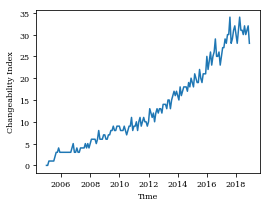

In [85]:
UpdateFreq_with_ChangeabilityIndex=pd.read_csv(data_folder+'UpdateFreq_with_ChangeabilityIndex.csv')
ax=UpdateFreq_with_ChangeabilityIndex.plot(x='Time',y='Changeability_Index',figsize=(4,3),rot=90,grid=False,legend=False)
ax.set_ylabel("Changeability Index")
ax.set_xlabel('Time')
xticks=list(range(12,len(UpdateFreq_with_ChangeabilityIndex['Time']),24))
xlabels=[UpdateFreq_with_ChangeabilityIndex['Time'][x][0:4] for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=0)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(8)
fig=ax.get_figure()
fig.savefig(figs_dir + 'changeability-over-time' + '.pdf',bbox_inches='tight')
fig.savefig(figs_dir + 'changeability-over-time' + '.png', dpi=300,bbox_inches='tight')